# 用于确定生成音符的参数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gen import Notes
notes = Notes()
print(notes.current_bpm(17.4))

143.67816091954023


In [30]:
# 本格用于调试generate函数的参数 调试完会加入Notes类
def generate(frames = 660, polyphonic = 0.16, near = 0.65):
    ft = np.zeros((7 * 12, frames))
    polyphonic_time = []
    current_time = 0
    last = None

    def a_note(last_note, sepcifyOffset = None):
        nonlocal current_time
        now = notes.fetch(
            last_note,
            near_future_len = 9 if np.random.uniform(0, 1) < near else 0
        )
        note, offset, length = now
        if sepcifyOffset != None:
            offset = sepcifyOffset
        note_row = ft[note]

        # 找到可以开始填充音符的位置
        current_time += offset
        if current_time >= frames:
            notes.putback(note)
            return False, None
        while current_time < frames and note_row[current_time] != 0:
            current_time += 1
        
        if current_time + length > frames:
            length = frames - current_time
            if length < notes.len_mean / 3:
                notes.putback(note)
                return False, None

        # 决定是否有同时演奏的音
        if np.random.uniform(0, 1) < polyphonic:
            polyphonic_time.append(current_time)

        note_row[current_time] = 2
        note_row[current_time + 1 : min(frames, current_time + length)] = 1
        current_time += length
        return True, now

    while current_time < frames:
        next, last = a_note(last)
        if not next:
            break
    
    # 处理polyphonic_time
    i = 0
    while i < len(polyphonic_time):
        current_time = polyphonic_time[i]
        if np.random.uniform(0, 1) < polyphonic:
            polyphonic_time.append(current_time)
        a_note(None, 0)
        i += 1
        
    return ft

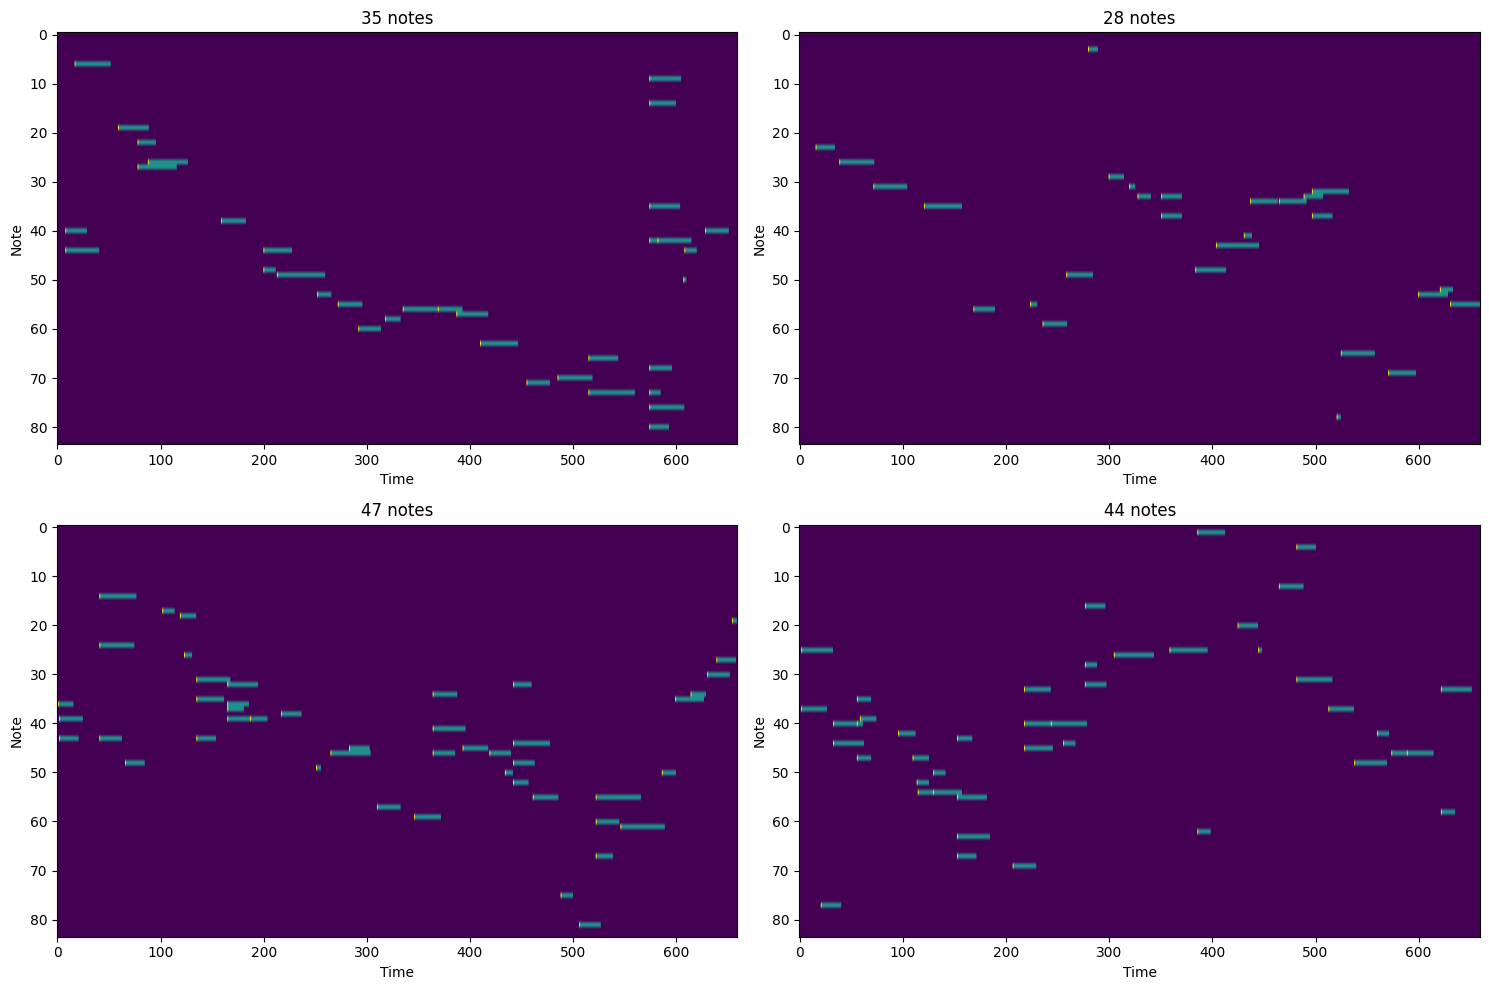

In [5]:
# Create a figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the data in each subplot
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        data = notes.generate(660, 0.16, 0.7)
        ax.imshow(data, aspect='auto', cmap='viridis')
        note_num = np.sum(data == 2)
        ax.set_title(f'{note_num} notes')
        ax.set_xlabel('Time')
        ax.set_ylabel('Note')

# Adjust layout
plt.tight_layout()
plt.show()

## 合成一个音频
生成numpy数组、导出为midi、合成为wav

In [6]:
import sys
sys.path.append('..')
from fluidsynth import Synth
s = Synth(22050, gain = 0.8)

sys.path.append('../..')
from utils.midiarray import numpy2midi

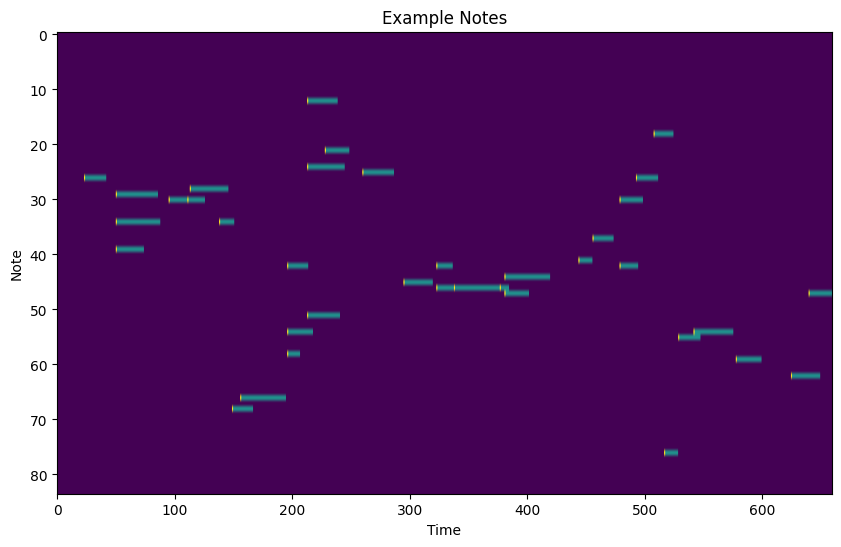

In [8]:
example = notes.generate(660, 0.16, 0.7)
np.save('example.npy', example)
numpy2midi(example, 384/22050, time_first=False, random=True, instrument=40).save('example.mid')
s.midi2audio("example.mid", "example.wav")
plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(example), aspect='auto', cmap='viridis')
plt.title('Example Notes')
plt.xlabel('Time')
plt.ylabel('Note')
plt.show()